In [1]:
import matplotlib.pyplot as plt
import os, shutil
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

## Load Data

In [2]:
train_data_path = "../../../02_data_crop/train"

images_per_folder = {}

for folder in os.listdir(train_data_path):
    len_images = len([name for name in os.listdir(os.path.join(train_data_path, folder)) if os.path.isfile(os.path.join(train_data_path, folder, name))])
    images_per_folder[folder] = len_images

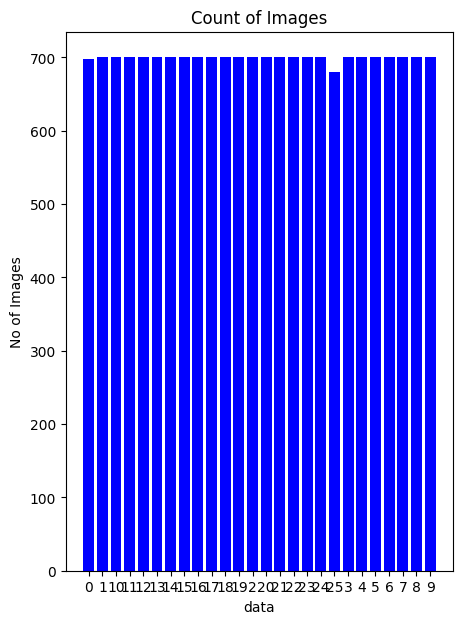

In [3]:
typex = images_per_folder.keys()
values = images_per_folder.values()

fig = plt.figure(figsize=(5,7))
plt.bar(typex, values, color="blue")
plt.xlabel('data')
plt.ylabel('No of Images')
plt.title('Count of Images')
plt.show()

In [4]:
val_data_path = "../../../02_data_crop/test"

images_per_folder = {}

for folder in os.listdir(val_data_path):
    len_images = len([name for name in os.listdir(os.path.join(val_data_path, folder)) if os.path.isfile(os.path.join(val_data_path, folder, name))])
    images_per_folder[folder] = len_images

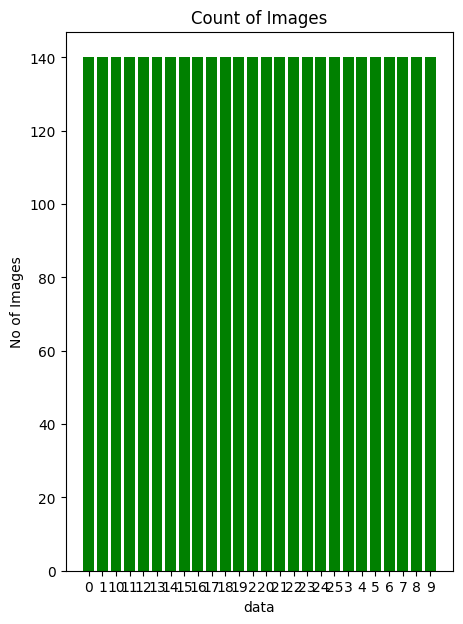

In [5]:
typex = images_per_folder.keys()
values = images_per_folder.values()

fig = plt.figure(figsize=(5,7))
plt.bar(typex, values, color="green")
plt.xlabel('data')
plt.ylabel('No of Images')
plt.title('Count of Images')
plt.show()

In [15]:
test_data_path = "../../../02_data_crop/val"

images_per_folder = {}

for folder in os.listdir(test_data_path):
    len_images = len([name for name in os.listdir(os.path.join(test_data_path, folder)) if os.path.isfile(os.path.join(test_data_path, folder, name))])
    images_per_folder[folder] = len_images

In [16]:
# all packages for training the model
import torch
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import random_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


## load data

In [17]:
# image = image.reshape((1,) + image.shape)

In [18]:
from sklearn.utils import shuffle
import keras
from natsort import natsorted

def load_data(images_path, image_size):
    X=[]
    y=[]
    folder = os.listdir(images_path)

    image_width, image_height = image_size

    for class_label in natsorted(folder):
        label = int(class_label)
        single_folder = os.path.join(images_path, class_label)

        for file in os.listdir(single_folder):
            filepath = os.path.join(single_folder, file)

            image = cv2.imread(filepath)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            #image = image.reshape((1,) + image.shape)

            X.append(image)
            y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    y = keras.utils.to_categorical(y)

    X,y = shuffle(X,y)

    return X, y


IMAGE_WIDTH, IMAGE_HEIGHT = (64,64)
X_train,y_train = load_data(train_data_path, (IMAGE_WIDTH, IMAGE_HEIGHT))

In [19]:
print(X_train.shape)
print(y_train.shape)

(10368, 64, 64, 3)
(10368, 26)


In [20]:
IMAGE_WIDTH, IMAGE_HEIGHT = (64,64)
X_val,y_val = load_data(val_data_path, (IMAGE_WIDTH, IMAGE_HEIGHT))
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_val shape: (1448, 64, 64, 3)
y_val shape: (1448, 26)


In [21]:
IMAGE_WIDTH, IMAGE_HEIGHT = (64,64)
X_test,y_test = load_data(test_data_path, (IMAGE_WIDTH, IMAGE_HEIGHT))
print(f'X_val shape: {X_test.shape}')
print(f'y_val shape: {y_test.shape}')

X_val shape: (1284, 64, 64, 3)
y_val shape: (1284, 26)


In [22]:
train_datagen = ImageDataGenerator(rescale=1./255,
                   horizontal_flip=0.4,
                   vertical_flip=0.4,
                   rotation_range=40,
                   shear_range=0.2,
                   width_shift_range=0.4,
                   height_shift_range=0.4,
                   fill_mode='nearest')

val_data_gen = ImageDataGenerator(rescale=1./255)

In [23]:
train_generator = train_datagen.flow_from_directory(train_data_path, batch_size=64, target_size=(64,64), class_mode='categorical', shuffle=True, seed=42, color_mode='rgb')
val_generator = train_datagen.flow_from_directory(val_data_path, batch_size=64, target_size=(64,64), class_mode='categorical', shuffle=True, seed=42, color_mode='rgb')
test_generator = train_datagen.flow_from_directory(test_data_path, batch_size=64, target_size=(64,64), class_mode='categorical', shuffle=True, seed=42, color_mode='rgb')

Found 10368 images belonging to 26 classes.
Found 1448 images belonging to 26 classes.
Found 1284 images belonging to 26 classes.


In [24]:
class_labels = train_generator.class_indices
class_name = {value: key for (key, value) in class_labels.items()}
print(class_name)

{0: '0', 1: '1', 2: '10', 3: '11', 4: '12', 5: '13', 6: '14', 7: '15', 8: '16', 9: '17', 10: '18', 11: '19', 12: '2', 13: '20', 14: '21', 15: '22', 16: '23', 17: '24', 18: '25', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9'}


## Model

In [25]:
base_model = VGG19(input_shape=(64,64,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(26, activation='sigmoid')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │     9,441,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 34,805,722 (132.77 MB)

 Trainable params: 14,781,338 (56.39 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [26]:
filepath = 'model.keras'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

In [27]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model_01.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'] )

c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [28]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs=5, callbacks=[es,cp,lrr], validation_data=val_generator)

Epoch 1/5


c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.0311 - loss: 3.3427
Epoch 1: val_loss improved from inf to 3.33539, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.0311 - loss: 3.3434 - val_accuracy: 0.0366 - val_loss: 3.3354 - learning_rate: 1.0000e-04
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.0415 - loss: 3.3432
Epoch 2: val_loss improved from 3.33539 to 3.31038, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.0411 - loss: 3.3433 - val_accuracy: 0.0401 - val_loss: 3.3104 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.0338 - loss: 3.3512
Epoch 3: val_loss improved from 3.31038 to 3.28756, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.0338 - loss: 3.3491 - val_accuracy: 0.0325 - val_loss: 3.2876 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.0625 - loss: 3.3199
Epoch

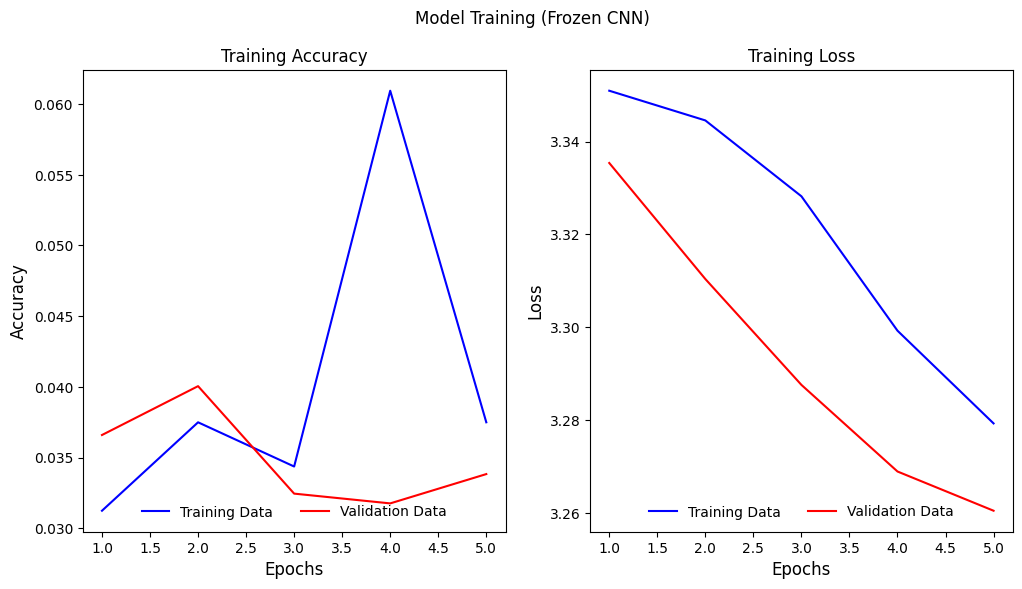

In [29]:
# plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle('Model Training (Frozen CNN)', fontsize=12)
max_epoch = len(history_01.history['accuracy']) + 1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='lower center', ncol=2)
plt.savefig('training_frozencnn.jpg', format='jpg', dpi=100, bbox_inches='tight')

In [30]:
model_01.save_weights('model_weights/vgg19_model_01.weights.h5', overwrite=True)

In [31]:
model_01.load_weights('model_weights/vgg19_model_01.weights.h5')
vgg_val_eval_01 = model_01.evaluate(val_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 535ms/step - accuracy: 0.0343 - loss: 3.2593


c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 524ms/step - accuracy: 0.0328 - loss: 3.2875


In [32]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing acc: {vgg_test_eval_01[1]}')

Validation Loss: 3.2581915855407715
Validation acc: 0.03591160103678703
Testing Loss: 3.293569326400757
Testing acc: 0.032710280269384384


In [33]:
filenames = test_generator.filenames
nb_sample = len(filenames)
vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose=1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

1284/1284 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step    


c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


## Incremental unfreezing und fine tuning

In [38]:
base_model = VGG19(include_top=False, input_shape=(64,64,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(26, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.weights.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4608)           │     9,441,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4608)           │             

 Total params: 34,805,722 (132.77 MB)

 Trainable params: 19,500,954 (74.39 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [39]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model_02.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'] )

c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [40]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs=5, callbacks=[es,cp,lrr], validation_data=val_generator)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.0303 - loss: 3.3056
Epoch 1: val_loss improved from 3.26043 to 3.25268, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.0305 - loss: 3.3040 - val_accuracy: 0.0359 - val_loss: 3.2527 - learning_rate: 1.0000e-04
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.0403 - loss: 3.2995
Epoch 2: val_loss improved from 3.25268 to 3.23933, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.0402 - loss: 3.2987 - val_accuracy: 0.0331 - val_loss: 3.2393 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.0592 - loss: 3.2639
Epoch 3: val_loss improved from 3.23933 to 3.23205, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.0586 - loss: 3.2644 - val_accuracy: 0.0539 - val_loss: 3.2320 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.0559 - loss

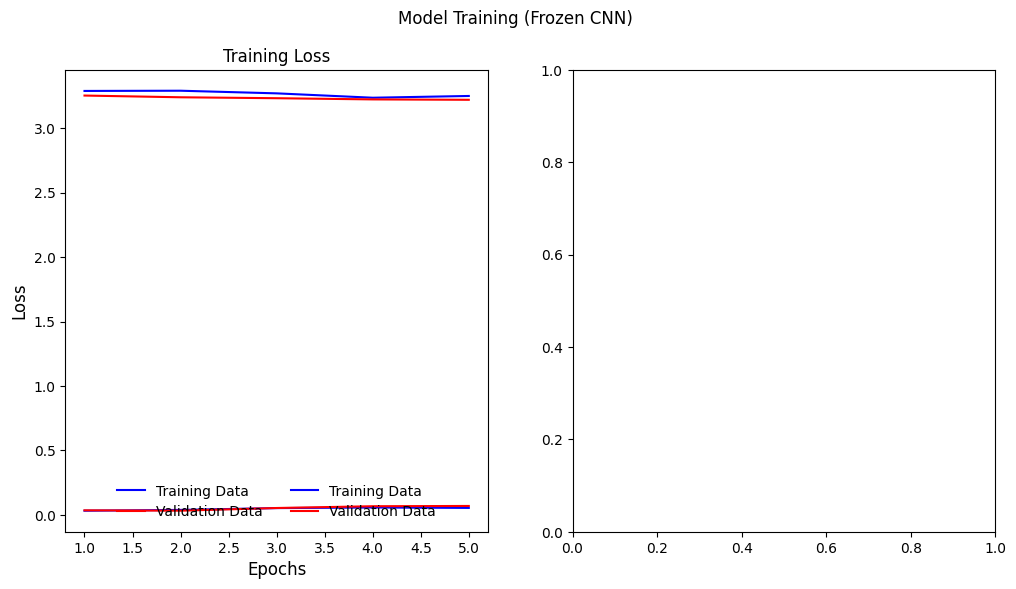

In [42]:
# plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle('Model Training (Frozen CNN)', fontsize=12)
max_epoch = len(history_02.history['accuracy']) + 1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax1.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Loss', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)
plt.savefig('training_frozencnn.jpg', format='jpg', dpi=100, bbox_inches='tight')

In [44]:
model_02.save_weights('model_weights/vgg19_model_02.weights.h5', overwrite=True)

In [45]:
model_02.load_weights('model_weights/vgg19_model_02.weights.h5')
vgg_val_eval_02 = model_02.evaluate(val_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 519ms/step - accuracy: 0.0671 - loss: 3.2311
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 515ms/step - accuracy: 0.0370 - loss: 3.2468


In [47]:
# unfreezing the entire network
base_model = VGG19(include_top=False, input_shape=(64,64,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(26, activation='softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights/vgg19_model_02.weights.h5')

In [48]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model_03.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'] )

c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [49]:
model_03.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4608)           │     9,441,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4608)           │             

 Total params: 34,805,722 (132.77 MB)

 Trainable params: 34,805,722 (132.77 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs=5, callbacks=[es,cp,lrr], validation_data=val_generator)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0621 - loss: 3.2382
Epoch 1: val_loss did not improve from 3.21983
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.0628 - loss: 3.2387 - val_accuracy: 0.0698 - val_loss: 3.2239 - learning_rate: 1.0000e-04
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0715 - loss: 3.2182
Epoch 2: val_loss improved from 3.21983 to 3.21218, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.0720 - loss: 3.2173 - val_accuracy: 0.0753 - val_loss: 3.2122 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0596 - loss: 3.2173
Epoch 3: val_loss improved from 3.21218 to 3.19534, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.0613 - loss: 3.2169 - val_accuracy: 0.0932 - val_loss: 3.1953 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0522 - loss: 3.2128
Epoch 4: val_loss improved from 3.19

In [51]:
model_03.load_weights('model_weights/vgg19_model_02.weights.h5')
vgg_val_eval_03 = model_03.evaluate(val_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 40 variables whereas the saved optimizer has 12 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 523ms/step - accuracy: 0.0680 - loss: 3.2170
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 503ms/step - accuracy: 0.0397 - loss: 3.2617
